In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!pip install graphviz
!pip install gplearn
!pip install optuna

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 14.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=e8fa436f6fe1db12d6b4895d2acfbf437c51e9fba25956cbacaaa7deef685fa5
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

#### Tamoxifen

In [4]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [5]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50

In [6]:
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cancer_driver_genes_df

,symbol,method_of_action,cosmic_moa,intogen_moa,gene_id
0,ABCB1,Act,NaN,Act,SIDG00064
1,ABI1,ambiguous,"TSG, fusion",ambiguous,SIDG00145
2,ABL1,Act,"oncogene, fusion",Act,SIDG00150
3,ABL2,Act,"oncogene, fusion",Act,SIDG00151
4,ACKR3,Act,"oncogene, fusion",Act,SIDG00205
...,...,...,...,...,...
778,ZNF814,Act,NaN,Act,SIDG42334
779,ZNF93,LoF,NaN,LoF,SIDG41755
780,ZNRF3,LoF,NaN,LoF,SIDG42403
781,ZRSR2,LoF,TSG,LoF,SIDG42422


In [7]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [8]:
X_selected = X[sym_list]
X_selected.shape

(406, 768)

#### Data Preprocessing

In [138]:
seed = 739
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_selected, target, random_state=seed, shuffle=True, test_size=0.2)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True, 
                                                random_state=seed, test_size=0.2)

In [139]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler

train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
# train_transformer = PowerTransformer().fit(X_train_df)
train_transformed = train_transformer.transform(X_train_df)
val_transformed = train_transformer.transform(X_val_df)
test_transformed = train_transformer.transform(X_test_df)

X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

In [140]:
X_train, y_train = X_train_df.values, y_train_df.values
X_val, y_val = X_val_df.values, y_val_df.values
X_test, y_test = X_test_df.values, y_test_df.values

In [94]:
import jax
from optax import Params
from jax import numpy as jnp
from optax import GradientTransformation
from typing import Any, NamedTuple
import tree_utils

class TrainingState(NamedTuple):
    params: hk.Params
    avg_params: hk.Params
    opt_state: optax.OptState

Momentum = Any  # An arbitrary pytree of `jnp.ndarrays`
GradMomentEstimates = optax.Params  # Same type as parameters
PreconditionerState = NamedTuple  # State of a preconditioner


class OptaxSGLDState(NamedTuple):
    """Optax state for the SGLD optimizer"""
    count: jnp.ndarray
    momentum: Momentum
    preconditioner_state: PreconditionerState

class BNNState(NamedTuple):
    params: hk.Params

def sgd_gradient_update(step_size_fn,
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGD optimizer.
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(params):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, params),
        preconditioner_state=preconditioner.init(params))

  def update_fn(key, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    def update_momentum(m, g):
      return momentum_decay * m + g * lr_sqrt
      


    momentum = jax.tree_map(update_momentum, state.momentum, gradient)
    updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    return updates, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


def sgld_gradient_update(step_size_fn,
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGLD optimizer.

  If momentum_decay is set to zero, we get the SGLD method [1]. Otherwise,
  we get the underdamped SGLD (SGHMC) method [2].

  Args:
    step_size_fn: a function taking training step as input and prodng the
      step size as output.
    momentum_decay: float, momentum decay parameter (default: 0).
    preconditioner: Preconditioner, an object representing the preconditioner
      or None; if None, identity preconditioner is used (default: None).  [1]
        "Bayesian Learning via Stochastic Gradient Langevin Dynamics" Max
        Welling, Yee Whye Teh; ICML 2011  [2] "Stochastic Gradient Hamiltonian
        Monte Carlo" Tianqi Chen, Emily B. Fox, Carlos Guestrin; ICML 2014
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(params):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, params),
        preconditioner_state=preconditioner.init(params))

  def update_fn(key, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)
    noise_std = jnp.sqrt(2 * (1 - momentum_decay))

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    noise_std = jnp.sqrt(2 * (1 - momentum_decay))
    noise, _ = tree_utils.normal_like_tree(gradient, key)
    noise = preconditioner.multiply_by_m_sqrt(noise, preconditioner_state)

    def update_momentum(m, g, n):
      return momentum_decay * m + g * lr_sqrt + n * noise_std
      


    momentum = jax.tree_map(update_momentum, state.momentum, gradient, noise)
    updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    return updates, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


class Preconditioner(NamedTuple):
  """Preconditioner transformation"""
  init: Any  # TODO @izmailovpavel: fix
  update_preconditioner: Any
  multiply_by_m_sqrt: Any
  multiply_by_m_inv: Any
  multiply_by_m_sqrt_inv: Any


class RMSPropPreconditionerState(PreconditionerState):
  grad_moment_estimates: GradMomentEstimates


def get_rmsprop_preconditioner(running_average_factor=0.99, eps=1.e-7):

  def init_fn(params):
    return RMSPropPreconditionerState(
        grad_moment_estimates=jax.tree_map(jnp.zeros_like, params))

  def update_preconditioner_fn(gradient, preconditioner_state):
    grad_moment_estimates = jax.tree_map(
        lambda e, g: e * running_average_factor + \
                     g**2 * (1 - running_average_factor),
        preconditioner_state.grad_moment_estimates, gradient)
    return RMSPropPreconditionerState(
        grad_moment_estimates=grad_moment_estimates)

  def multiply_by_m_inv_fn(vec, preconditioner_state):
    return jax.tree_map(lambda e, v: v / (eps + jnp.sqrt(e)),
                        preconditioner_state.grad_moment_estimates, vec)

  def multiply_by_m_sqrt_fn(vec, preconditioner_state):
    return jax.tree_map(lambda e, v: v * jnp.sqrt(eps + jnp.sqrt(e)),
                        preconditioner_state.grad_moment_estimates, vec)

  def multiply_by_m_sqrt_inv_fn(vec, preconditioner_state):
    return jax.tree_map(lambda e, v: v / jnp.sqrt(eps + jnp.sqrt(e)),
                        preconditioner_state.grad_moment_estimates, vec)

  return Preconditioner(
      init=init_fn,
      update_preconditioner=update_preconditioner_fn,
      multiply_by_m_inv=multiply_by_m_inv_fn,
      multiply_by_m_sqrt=multiply_by_m_sqrt_fn,
      multiply_by_m_sqrt_inv=multiply_by_m_sqrt_inv_fn)


class IdentityPreconditionerState(PreconditionerState):
  """Identity preconditioner is stateless."""


def get_identity_preconditioner():

  def init_fn(_):
    return IdentityPreconditionerState()

  def update_preconditioner_fn(*args, **kwargs):
    return IdentityPreconditionerState()

  def multiply_by_m_inv_fn(vec, _):
    return vec

  def multiply_by_m_sqrt_fn(vec, _):
    return vec

  def multiply_by_m_sqrt_inv_fn(vec, _):
    return vec

  return Preconditioner(
      init=init_fn,
      update_preconditioner=update_preconditioner_fn,
      multiply_by_m_inv=multiply_by_m_inv_fn,
      multiply_by_m_sqrt=multiply_by_m_sqrt_fn,
      multiply_by_m_sqrt_inv=multiply_by_m_sqrt_inv_fn)

def make_cyclical_lr_fn(lr_0, total, num_cycles):
    k = total // num_cycles
    def schedule_fn(step):
        rk = (step % k)
        cos_inner = jnp.pi * rk
        cos_inner /= k
        cos_out = jnp.cos(cos_inner) + 1
        lr = 0.5*cos_out*lr_0

        return lr

    return schedule_fn

#### BNN without BG

In [95]:
class BayesNN():
    def __init__(self, sgd_optim, sgld_optim, temperature, sigma, data_size, hidden_sizes, act_fn=jax.nn.relu):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim
        self._forward = hk.without_apply_rng(hk.transform(self._forward_fn))
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.temperature = temperature
        self.sigma = sigma
        self.data_size = data_size
        self.add_noise = False

        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)
        # self.weight_prior = tfd.Laplace(0, self.sigma)

    def init(self, rng, x):
        params = self._forward.init(rng, x)
        opt_state = self.optimiser.init(params)
        return params, opt_state

    def apply(self, params, x):
        return self._forward.apply(params, x).ravel()


    def update(self, key, params, opt_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
        else:
            self.optimiser = self.sgd_optim
        grads = jax.grad(self.loss)(params, x, y)
        updates, opt_state = self.optimiser.update(key, grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    def _forward_fn(self, x):
        init_fn = hk.initializers.VarianceScaling()
        for hd in self.hidden_sizes:
            x = hk.Linear(hd, w_init=init_fn, b_init=init_fn)(x)
            x = self.act_fn(x)

        x = hk.Linear(1)(x)
        return x

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1))/self.temperature),
                                                                        params))

        return sum(logprob_tree)

    def log_likelihood(self, params, x, y):
        preds = self.apply(params, x).ravel()
        log_prob = jnp.sum(tfd.Normal(preds, self.temperature).log_prob(y))
        batch_size = x.shape[0]
        log_prob = (self.data_size / batch_size)*log_prob
        return log_prob

    def loss(self, params, x, y):
        logprob_prior = self.log_prior(params)
        logprob_likelihood = self.log_likelihood(params, x, y)
        return logprob_likelihood + logprob_prior


In [59]:
import seaborn as sns

def visualize_weights(param, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    weights = jax.tree_util.tree_leaves(param)
    weights = [w.reshape(-1) for w in weights if len(w.shape) > 1]

    ## Plotting
    columns = len(weights)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(weights):
        key = f'Layer {g_idx * 2} - weights'
        key_ax = ax[g_idx%columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(f"weight distribution for each layer", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

def visualize_gradients(model, params, x, y, color="C0"):
    """
    Inputs:
        model - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    grads = jax.grad(model.loss)(params, x, y)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(grads):
        key = f'Layer {g_idx * 2} - weights'
        key_ax = ax[g_idx%columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(f"Gradient magnitude distribution for activation function {model.act_fn.__class__.__name__}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

def visualize_activations(model, color="C0"):
    activations = model.activations

    ## Plotting
    columns = 4
    rows = int(np.ceil(len(activations)/columns))
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    act_fn_name = model.act_fn.__class__.__name__
    for idx, activ in enumerate(activations):
        key_ax = ax[idx//columns][idx%columns]
        sns.histplot(data=jax.device_get(activ).reshape(-1), bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {idx} - {'Dense' if idx%2==0 else act_fn_name}")
    fig.suptitle(f"Activation distribution for activation function {act_fn_name}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

In [60]:
from sklearn.metrics import r2_score
import torch
torch.backends.cudnn.deterministic = True

def init_bnn_model(seed, train_loader, epochs, lr_0, num_cycles, temp, sigma, hidden_sizes, act_fn):
    torch.manual_seed(seed)
    num_batches = len(train_loader)
    data_size = X.shape[0]
    total_steps = num_batches*epochs
    step_size_fn = make_cyclical_lr_fn(lr_0, total_steps, num_cycles)
    sgd_optim = sgd_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    sgld_optim = sgld_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())

    model = BayesNN(sgd_optim, sgld_optim,
                      temp, sigma, data_size, hidden_sizes, act_fn)

    return model


def train_bnn_model(seed, train_loader, epochs, num_cycles, beta, lr_0,
                       hidden_sizes, temp, sigma, act_fn=jax.nn.relu):

    rng_key = jax.random.PRNGKey(seed)
    model = init_bnn_model(seed, train_loader, epochs, lr_0, num_cycles, temp, sigma, hidden_sizes, act_fn)

    # cycle_len = epochs // num_cycles
    num_batches = len(train_loader)
    M = (epochs*num_batches) // num_cycles
    init_params, init_opt_state = model.init(rng_key, next(iter(train_loader))[0])


    states = []
    params, opt_state = init_params, init_opt_state
    step = 0
    key = rng_key
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            rk = (step % M) / M
            params, opt_state = model.update(key, params, opt_state, batch_x, batch_y)
            if rk > beta:
                model.add_noise = True
                states.append(params)
            else:
                model.add_noise = False
            step += 1

    return model, states

def eval_bnn_model(model, X, y, params):

    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, param in enumerate(params):
            preds = model.apply(param, X).ravel()
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    else:
        y_preds = model.apply(params, gammas, X).ravel()
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))

    return rmse

def score_bnn_model(model, X, y, params):
    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, param in enumerate(params):
            preds = model.apply(param, X).ravel()
            # preds_mean = preds[::2]
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan
    else:
        y_preds = model.apply(params, X)
        preds_mean = y_preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan

    return rmse, r2

def eval_per_model_score(model, X, y, params):
    scores = []

    for param in params:
        preds = model.apply(param, X).ravel()
        # preds_mean = preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds)**2))
        scores.append(rmse)



    return np.array(scores)

In [61]:
epochs = 1000
num_cycles = 10
batch_size = 80
beta = 0.80
lr_0 = 1e-3
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=False)
bnn_model, bnn_states = train_bnn_model(seed, data_loader, epochs, num_cycles, beta, lr_0,
                    hidden_sizes, temp, sigma, act_fn=jax.nn.swish)
len(bnn_states)

790

In [62]:
bnn_rmse_val, bnn_r2_val = score_bnn_model(bnn_model, X_val, y_val, bnn_states)
bnn_rmse_test, bnn_r2_test = score_bnn_model(bnn_model, X_test, y_test, bnn_states)
print(f"Val RMSE: {bnn_rmse_val}, r2_score: {bnn_r2_val}")
print(f"Test RMSE: {bnn_rmse_test}, r2_score: {bnn_r2_test}")

Val RMSE: 0.5375946164131165, r2_score: 0.09307623715185953
Test RMSE: 0.5161241888999939, r2_score: 0.23625649115521785


(array([ 79.,   0., 237., 158., 158.,  79.,   0.,   0.,   0.,  79.]),
 array([0.5248595 , 0.53419375, 0.543528  , 0.5528623 , 0.56219655,
        0.5715308 , 0.580865  , 0.5901993 , 0.59953356, 0.6088678 ,
        0.6182021 ], dtype=float32),
 <BarContainer object of 10 artists>)

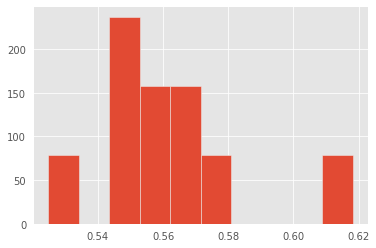

In [18]:
bnn_val_losses = eval_per_model_score(bnn_model, X_val, y_val, bnn_states)
plt.hist(bnn_val_losses)

In [63]:
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
np.count_nonzero(J)

11862

In [64]:
def disc_sgd_gradient_update(step_size_fn,
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGD optimizer.
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(gamma):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, gamma),
        preconditioner_state=preconditioner.init(gamma))

  def update_fn(key, gamma, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    def update_momentum(m, g):
      return momentum_decay * m + g * lr_sqrt
      
    def proposal(theta, g, step_size):
        diff = (0.5*g*-(2*theta - 1)) - (1./(2*step_size))
        prob = jax.nn.sigmoid(diff)
        prob_inv = 1 - prob
        prob = prob[...,None]
        prob_inv = prob_inv[...,None]
        delta = jnp.argmax(jnp.concatenate([prob, prob_inv], axis=1), axis=-1)  

        theta_delta = (1 - theta)*delta + theta*(1 - delta)
        return theta_delta*1.

    momentum = jax.tree_map(update_momentum, state.momentum, gradient)
    # updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    # updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    gamma = proposal(gamma, gradient, lr)

    return gamma, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


def disc_sgld_gradient_update(step_size_fn, 
                         momentum_decay=0.,
                         preconditioner=None):
  """Optax implementation of the SGLD optimizer.

  If momentum_decay is set to zero, we get the SGLD method [1]. Otherwise,
  we get the underdamped SGLD (SGHMC) method [2].

  Args:
    step_size_fn: a function taking training step as input and prodng the
      step size as output.
    seed: int, random seed.
    momentum_decay: float, momentum decay parameter (default: 0).
    preconditioner: Preconditioner, an object representing the preconditioner
      or None; if None, identity preconditioner is used (default: None).  [1]
        "Bayesian Learning via Stochastic Gradient Langevin Dynamics" Max
        Welling, Yee Whye Teh; ICML 2011  [2] "Stochastic Gradient Hamiltonian
        Monte Carlo" Tianqi Chen, Emily B. Fox, Carlos Guestrin; ICML 2014
  """

  if preconditioner is None:
    preconditioner = get_identity_preconditioner()

  def init_fn(gamma):
    return OptaxSGLDState(
        count=jnp.zeros([], jnp.int32),
        momentum=jax.tree_map(jnp.zeros_like, gamma),
        preconditioner_state=preconditioner.init(gamma))

  def update_fn(key, gamma, gradient, state):
    lr = step_size_fn(state.count)
    lr_sqrt = jnp.sqrt(lr)

    preconditioner_state = preconditioner.update_preconditioner(
        gradient, state.preconditioner_state)

    def update_momentum(m, g):
      return momentum_decay * m + g * lr_sqrt
      
    def proposal(key, theta, g, step_size):
        diff = (-0.5*g*(2*theta - 1)) - (1./(2*step_size))
        delta = jax.random.bernoulli(key, jax.nn.sigmoid(diff))
        theta_delta = (1 - theta)*delta + theta*(1 - delta)
        return theta_delta*1.



    momentum = jax.tree_map(update_momentum, state.momentum, gradient)
    # updates = preconditioner.multiply_by_m_inv(momentum, preconditioner_state)
    # updates = jax.tree_map(lambda m: m * lr_sqrt, updates)
    gamma = proposal(key, gamma, gradient, lr)


    return gamma, OptaxSGLDState(
        count=state.count + 1,
        momentum=momentum,
        preconditioner_state=preconditioner_state)

  return GradientTransformation(init_fn, update_fn)


#### BNN with BG

In [65]:
class BgBayesNN():
    def __init__(self, sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim, 
                        temperature, sigma, data_size, hidden_sizes, 
                        J, eta, mu,
                        act_fn=jax.nn.relu):
        self.hidden_sizes = hidden_sizes
        self.act_fn = act_fn
        self.sgd_optim = sgd_optim
        self.sgld_optim = sgld_optim
        self.optimiser = sgd_optim

        self.disc_optimiser = disc_sgd_optim
        self.disc_sgd_optim = disc_sgd_optim
        self.disc_sgld_optim = disc_sgld_optim

        self._forward = hk.transform(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.temperature = temperature
        self.sigma = sigma
        self.data_size = data_size
        self.add_noise = False
        self.J = J
        self.eta = eta
        self.mu = mu

        # weight_decay = self.sigma*self.temperature
        # self.weight_prior = tfd.Normal(0, self.sigma)
        self.weight_prior = tfd.StudentT(df=2, loc=0, scale=self.sigma)
        # self.weight_prior = tfd.Horseshoe(scale=self.sigma)
        # self.weight_prior = tfd.Laplace(0, self.sigma)

    def init(self, rng, x):
        gamma = tfd.Bernoulli(0.5*jnp.ones(x.shape[-1])).sample(seed=rng)*1.
        params = self._forward.init(rng, x, gamma)
        opt_state = self.optimiser.init(params)
        disc_opt_state = self.disc_optimiser.init(gamma)
        return params, gamma, opt_state, disc_opt_state

    def apply(self, params, gamma, x):
        return self._forward.apply(params, None, x, gamma).ravel()

    
    def loss(self, params, gamma, x, y):
        logprob_prior = self.log_prior(params)
        logprob_likelihood = self.log_likelihood(params, gamma, x, y)
        return logprob_likelihood + logprob_prior

    def update(self, key, params, gamma, opt_state, disc_opt_state, x, y):
        if self.add_noise:
            self.optimiser = self.sgld_optim
            self.disc_optimiser = self.disc_sgld_optim
        else:
            self.optimiser = self.sgd_optim
            self.disc_optimiser = self.disc_sgd_optim

        contin_loss = lambda p: self.log_prior(params) + self.log_likelihood(p, gamma, x, y)

        grads = jax.grad(contin_loss)(params)
        updates, opt_state = self.optimiser.update(key, grads, opt_state)
        params = optax.apply_updates(params, updates)

        disc_loss = lambda g: self.ising_prior(g) + self.log_likelihood(params, g, x, y)
        disc_logprob, disc_grads = jax.value_and_grad(disc_loss)(gamma)
        gamma, disc_opt_state = self.disc_optimiser.update(key, gamma, disc_grads, disc_opt_state)
        return params, gamma, opt_state, disc_opt_state

    def _forward_fn(self, x, gamma):
        x = x @ jnp.diag(gamma)
        init_fn = hk.initializers.VarianceScaling()
        for hd in self.hidden_sizes:
            x = hk.Linear(hd, w_init=init_fn)(x)
            x = self.act_fn(x)

        x = hk.Linear(1)(x)
        return x

    def log_prior(self, params):
        """Computes the Gaussian prior log-density."""
        logprob_tree = jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: jnp.sum(self.weight_prior.log_prob(x.reshape(-1))/self.temperature), 
                                                                            params))
        
        return sum(logprob_tree)

    def log_likelihood(self, params, gamma, x, y):
        preds = self.apply(params, gamma, x).ravel()
        # preds_mean, preds_std = preds[::2], preds[1::2]
        # print(preds.shape)
        # print(preds_mean.shape)
        # print(preds_std.shape)
        # preds_std = jax.nn.softplus(preds_std.squeeze())
        # preds_mean = preds_mean.squeeze()
        # preds_std = (preds_std**2)*self.temperature
        log_prob = jnp.sum(tfd.Normal(preds, self.temperature).log_prob(y))
        # log_prob = jnp.sum(tfd.MultivariateNormalDiag(preds_mean, preds_std).log_prob(y))
        batch_size = x.shape[0]
        log_prob = (self.data_size / batch_size)*log_prob
        return log_prob

    def ising_prior(self, gamma):
        """Log probability of the Ising model - prior over the discrete variables"""
        return (0.5*self.eta*(gamma.T @ self.J @ gamma) - self.mu*jnp.sum(gamma)) / self.temperature
        # x = (2 * gamma) - 1
        # xg = x @ self.J
        # xgx = (xg * x).sum(-1)
        # return (0.5*self.eta*xgx + self.mu*jnp.sum(x)) / self.temperature

In [66]:
import torch

def init_bg_bnn_model(seed, train_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, act_fn):
    torch.manual_seed(seed)
    num_batches = len(train_loader)
    data_size = X.shape[0]
    total_steps = num_batches*epochs
    step_size_fn = make_cyclical_lr_fn(lr_0, total_steps, num_cycles)
    # disc_step_size_fn = make_cyclical_lr_fn(disc_lr_0, total_steps, num_cycles)
    disc_step_size_fn = lambda step: disc_lr_0
    sgd_optim = sgd_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    sgld_optim = sgld_gradient_update(step_size_fn, momentum_decay=0, preconditioner=get_rmsprop_preconditioner())
    disc_sgd_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())
    disc_sgld_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())

    model = BgBayesNN(sgd_optim, sgld_optim, disc_sgd_optim, disc_sgld_optim,
                      temp, sigma, data_size, hidden_sizes,
                      J, eta, mu, act_fn)

    return model


def train_bg_bnn_model(seed, train_loader, epochs, num_cycles, beta, lr_0, disc_lr_0,
                    hidden_sizes, temp, sigma, eta, mu, J, act_fn=jax.nn.relu):

    rng_key = jax.random.PRNGKey(seed)
    model = init_bg_bnn_model(seed, train_loader, epochs, lr_0, disc_lr_0, num_cycles, temp, sigma, hidden_sizes, J, eta, mu, act_fn)

    cycle_len = epochs // num_cycles
    num_batches = len(train_loader)
    M = (epochs*num_batches) // num_cycles
    init_params, init_gamma, init_opt_state, init_disc_opt_state = model.init(rng_key, next(iter(train_loader))[0])


    states = []
    disc_states = []
    val_losses = []
    params, gamma, opt_state, disc_opt_state = init_params, init_gamma, init_opt_state, init_disc_opt_state
    step = 0
    key = rng_key
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            rk = (step % M) / M
            params, gamma, opt_state, disc_opt_state = model.update(key, params, gamma, opt_state, disc_opt_state, batch_x, batch_y)
            if rk > beta:
                states.append(params)
                disc_states.append(gamma)
                model.add_noise = True
            else:
                model.add_noise = False
            step += 1
        # if (epoch % cycle_len) + 1 > (cycle_len - n_models_per_cycle):
        #     # print(epoch)
        #     states.append(params)
        #     disc_states.append(gamma)
        # val_loss = eval_bg_bnn_model(model, X_val, y_val, params, gamma)
        # val_losses.append(val_loss)

    return model, states, disc_states

def eval_bg_bnn_model(model, X, y, params, gammas):

    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, (param, gamma) in enumerate(zip(params, gammas)):
            preds = model.apply(param, gamma, X).ravel()
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    else:
        y_preds = model.apply(params, gammas, X).ravel()
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))

    return rmse

def score_bg_bnn_model(model, X, y, params, gammas):
    if isinstance(params, list):
        y_preds = np.zeros((len(params), len(y)))
        for i, (param, gamma) in enumerate(zip(params, gammas)):
            preds = model.apply(param, gamma, X).ravel()
            # preds_mean = preds[::2]
            y_preds[i] = preds

        y_preds = np.mean(y_preds, axis=0)
        rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan
    else:
        y_preds = model.apply(params, gammas, X)
        preds_mean = y_preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
        if np.isfinite(y_preds).all():
            r2 = r2_score(y, y_preds)
        else:
            r2 = np.nan

    return rmse, r2

def eval_per_model_score_bg(model, X, y, params, gammas):
    scores = []

    for param, gamma in zip(params, gammas):
        preds = model.apply(param, gamma, X).ravel()
        # preds_mean = preds[::2]
        rmse = jnp.sqrt(jnp.mean((y - preds)**2))
        scores.append(rmse)



    return np.array(scores)

In [22]:
import operator
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration

import math

def evaluate_bnn_bg_models(model, X, y, params, gammas):
    eval_fn = lambda p, g: model.apply(p, g, X).ravel()
    preds = jax.vmap(eval_fn)(params, gammas)
    preds = preds.reshape(-1, preds.shape[-1])
    losses = jax.vmap(lambda x, z: jnp.sqrt(jnp.mean((x - z)**2)), in_axes=(0, None))(preds, y)
    # mean_loss = jnp.sqrt(jnp.mean(losses, axis=-1))
    return jnp.mean(losses)


def get_feats_dropout_loss(model, params, gammas, X, y):
    var_loss_dict = {"feats_idx": [], "num_models": [] , "loss_on": [], "loss_off": [], "loss_diff": []}
    
    disc_states = tree_utils.tree_stack(gammas)
    contin_states = tree_utils.tree_stack(params)
    
    
    print(disc_states.shape)
    eval_fn = jax.jit(lambda X, y, params, gammas: evaluate_bnn_bg_models(model, X, y, params, gammas))
    p = X.shape[1]

    for idx in range(p):
        # loss_diffs = []
        # for i, (param, gamma) in enumerate(zip(params, gammas)):
        #     if gamma[idx] == 1:
        #         loss_on = eval_bg_bnn_model(model, X, y, [param], [gamma])
        #         # Turn off the feature
        #         gamma_off = gamma.at[idx].set(0)
        #         loss_off = eval_bg_bnn_model(model, X, y, [param], [gamma_off])
        #
        #         loss_diffs.append((loss_on - loss_off))
        #     else:
        #         loss_diffs.append(0)
        # fi_matrix.append(loss_diffs)
        # idx = feats_idx[i]
        idx_on = np.argwhere(disc_states[:,idx] == 1.).ravel()
        loss_on, loss_off = 0., 0.
        if idx_on.size == 0: ## irrelevant feature
            loss_diff = 1e9
        else:
            disc_states_on = disc_states[idx_on]
            params_on = jax.tree_util.tree_map(lambda x: x[idx_on], contin_states)
            loss_on = eval_fn(X, y, params_on, disc_states_on)

            # Turn-off the variable, and see how the loss changes
            disc_states_off = disc_states_on.at[:,idx].set(0)
            loss_off = eval_fn(X, y, params_on, disc_states_off)

            # loss_diff = (loss_on - loss_off) * (len(idx_on) / num_models)
            loss_diff = (loss_on - loss_off)


        var_loss_dict["feats_idx"].append(idx)
        var_loss_dict["num_models"].append(idx_on.size)
        var_loss_dict["loss_on"].append(loss_on)
        var_loss_dict["loss_off"].append(loss_off)
        var_loss_dict["loss_diff"].append(loss_diff)


    var_loss_df = pd.DataFrame(var_loss_dict).sort_values(by="loss_diff")

    return var_loss_df

def get_gene_names(gene_cols):
    return [gene.split("(")[0].strip() for gene in gene_cols]

##### Optuna

In [134]:
import optuna

epochs = 1000
num_cycles = 10
batch_size = 80
hidden_sizes = [1000, 500, 300, 100]
lr_0 = 1e-3
act_fn = jax.nn.swish

def objective(trial, seed, x_train, x_val, y_train, y_val, J, epochs, num_cycles,
              batch_size, hidden_sizes, lr_0, act_fn):

    disc_lr = trial.suggest_float("disc_lr", 0.1, 0.9)
    temp = trial.suggest_categorical("temp", [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.])
    beta = trial.suggest_float("beta", 0.6, 0.9)
    eta = 1.0
    mu = trial.suggest_float("mu", 1.0, 1e2, log=True)
    sigma = 1.0
    torch.manual_seed(seed)
    data_loader = NumpyLoader(NumpyData(x_train, y_train), batch_size=batch_size, shuffle=False)

    bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, beta, lr_0, disc_lr,
                                                           hidden_sizes, temp, sigma, eta, mu, J, act_fn)

    rmse = eval_bg_bnn_model(bg_bnn_model, x_val, y_val, states, disc_states)
    return rmse

In [130]:
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler)
study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J, epochs, num_cycles, batch_size, hidden_sizes, lr_0, act_fn), timeout=300)

In [131]:
bg_config = study.best_params
print(bg_config)

{'disc_lr': 0.2437504314724081, 'temp': 0.01, 'beta': 0.8543741461429453, 'mu': 6.28040232208994}


In [96]:
import pickle
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
bg_config = pickle.load(open(f"{save_dir}/configs/bnn_config_bg_s_{seed}_v2.pkl", "rb"))
bg_config

{'disc_lr': 0.10851902804665374,
 'temp': 0.01,
 'beta': 0.750480777514709,
 'mu': 10.18776343605859}

In [135]:
rng_key = jax.random.PRNGKey(seed)

disc_lr_0 = bg_config["disc_lr"]
temp, sigma = bg_config["temp"], 1.0
eta, mu = 1.0, bg_config["mu"]
beta = bg_config["beta"]

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=False)
val_data = NumpyData(X_val, y_val)

bg_bnn_model, bnn_bg_states, bg_disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, beta, lr_0, disc_lr_0,
                        hidden_sizes, temp, sigma, eta, mu, J, act_fn=jax.nn.swish)

len(bnn_bg_states)

580

In [ ]:
bnn_bg_rmse_val, bnn_bg_r2_val = score_bg_bnn_model(bg_bnn_model, X_val, y_val, bnn_bg_states, bg_disc_states)
bnn_bg_rmse_test, bnn_bg_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, bnn_bg_states, bg_disc_states)
print(f"Val  RMSE: {bnn_bg_rmse_val}, r2_score: {bnn_bg_r2_val}")
print(f"Test RMSE: {bnn_bg_rmse_test}, r2_score: {bnn_bg_r2_test}")

In [ ]:
bnn_lst_loss = np.sort(bnn_val_losses)[0]
bnn_lst_loss

In [ ]:
model_idx = np.argwhere((bnn_bg_val_losses - bnn_lst_loss) < -0.1).squeeze()
val_losses_sel = bnn_bg_val_losses[model_idx]
plt.hist(val_losses_sel)

In [ ]:
bnn_bg_states_sel = list(operator.itemgetter(*model_idx)(bnn_bg_states))
bg_disc_states_sel = list(operator.itemgetter(*model_idx)(bg_disc_states))
len(bnn_bg_states_sel)

In [ ]:
bnn_bg_rmse_val, bnn_bg_r2_val = score_bg_bnn_model(bg_bnn_model, X_val, y_val, bnn_bg_states_sel, bg_disc_states_sel)


In [ ]:
gamma_mean = np.mean(np.array(bg_disc_states), axis=0)
plt.hist(gamma_mean)

#### Input Gradients

In [ ]:
def get_input_gradient(model, X, y, params, gammas):
    n, p = X.shape
    k = len(params)
    mat = np.zeros((k, n, p))

    for i in range(n):
        x_i, y_i = X[i], y[i]
        for j in range(k):
            param, gamma = params[j], gammas[j]
            gx = jax.grad(model.log_likelihood, argnums=2)(param, gamma, x_i, y_i)
            # gx = jax.grad(lambda p, g, x: model.apply(p, g, x).squeeze(), argnums=2)(param, gamma, x_i)
            mat[j, i] = gx

    return mat

#### Integrated Gradients

In [152]:
def integrated_gradients(model, st, disc_st, x, N):

    params = tree_utils.tree_stack(st)
    gammas = tree_utils.tree_stack(disc_st)

    p = x.shape[-1]
    baseline = jnp.zeros((1, p))
    t = jnp.linspace(0, 1, N).reshape(-1, 1)
    path = baseline * (1 - t) + x * t

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return jnp.mean(jax.vmap(jax.grad(lambda param, gamma, p: model.apply(param, gamma, p).squeeze(), argnums=2), in_axes=(0, 0, None))(params, gammas, pi), axis=0)
        # return jnp.mean(jax.vmap(jax.grad(lambda param, gamma, p: model.log_likelihood(param, gamma, p, y).squeeze(), argnums=2), in_axes=(0, 0, None,))(params, gammas, pi), axis=0)

    gs = jax.vmap(get_grad)(path)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0, keepdims=True) * (x - baseline)
    return ig.squeeze()

def plot_grad(g, ax=None):
    # g = np.array(g)
    if ax is None:
        plt.figure(figsize=(16, 8))
        ax = plt.gca()

    s = g.shape[0]
    ax.bar(np.arange(s), height=g)
    ax.set_xticks(range(s))
    # ax.set_xticklabels(range(s))
    ax.set_xlabel("Feature $x_i$")
    ax.set_ylabel(r"Gradient $\frac{\partial \hat{f}(\vec{x})}{\partial x_i}$")



In [156]:
igs = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, None))(bg_bnn_model, bnn_bg_states, bg_disc_states, X_val, 100)

In [ ]:
igs

In [ ]:
from tqdm import tqdm
igs = np.zeros_like(X_val)
for i in tqdm(range(X_val.shape[0])):
    igs[i] = integrated_gradients(bg_bnn_model, bnn_bg_states_sel, bg_disc_states_sel, X_val[i], 100)

In [ ]:
igs_mean = np.mean(np.abs(igs), axis=0)
plot_grad(igs_mean)

In [ ]:
X_train_df.iloc[:,np.argsort(igs_mean)[::-1][:20]]

#### Shapley Valeus

In [ ]:
def shapley(key, model, i, sm, sampled_x):
    m, p = sampled_x.shape
    z_choice = jax.random.bernoulli(key, shape=(m, p))*1.
    #construct with and w/o ith feature
    z_choice = z_choice.at[:, i].set(0.0)
    z_choice_i = z_choice.at[:, i].set(1.0)
    # select them via multiplication
    z = sm*z_choice + sampled_x * (1 - z_choice)
    z_i = sm*z_choice_i + sampled_x * (1 - z_choice_i)

    v = model(z_i) - model(z)
    return jnp.squeeze(jnp.mean(v, axis=0))

In [ ]:
from tqdm import tqdm
params, gammas = tree_utils.tree_stack(bnn_bg_states), tree_utils.tree_stack(bg_disc_states)
model_apply = lambda x: jnp.mean(jax.vmap(lambda p, g, x: bg_bnn_model.apply(p, g, x), in_axes=(0, 0, None))(params, gammas, x), axis=0)


n, p = X_val.shape
sl = jnp.arange(p)

svs = np.zeros_like(X_val)
key, _ = jax.random.split(rng_key, 2)
bshapley = jax.vmap(shapley, in_axes=(None, None, 0, None, None, None))
M = 20

for i in tqdm(range(n)):
    key, _ = jax.random.split(key, 2)
    sm = X_val[i]
    sampled_idx = jax.random.choice(key, jnp.arange(n), shape=(M,), replace=False).reshape(1, -1)
    sampled_x, sampled_y = X_val[sampled_idx].squeeze(), y_val[sampled_idx].squeeze()
    sv = bshapley(key, model_apply, sl, sm, sampled_x, sampled_y)
    svs[i] = sv

In [ ]:
shapley_mean = np.mean(svs, axis=0)

In [ ]:
model_apply(X_val[10])

#### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score

def train_rf_model(seed, X, y):

    cv = KFold(n_splits=5, random_state=seed, shuffle=True)

    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]
    }

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0)
    grid_cv = GridSearchCV(estimator = rf_reg, param_grid = param_grid,
                            cv = cv, n_jobs = -1, verbose = 0, scoring="r2").fit(X, y)

    rf_reg = RandomForestRegressor(random_state=seed, max_samples=1.0,**grid_cv.best_params_)
    rf_reg.fit(X, y)

    return rf_reg

def eval_rf_model(model, X, y):
    y_preds = model.predict(X)
    rmse = jnp.sqrt(jnp.mean((y - y_preds)**2))
    r2 = r2_score(y, y_preds)
    return rmse, r2 

In [159]:
import pickle
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# rf_model = train_rf_model(seed, X_train, y_train)
rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
rmse_val, r2_val = eval_rf_model(rf_model, X_val, y_val)
rmse_test, r2_test = eval_rf_model(rf_model, X_test, y_test)

print(f"Val RMSE: {rmse_val}, r2_score:  {r2_val}")
print(f"Test RMSE: {rmse_test}, test_score:  {r2_test}")

Val RMSE: 0.4816979765892029, r2_score:  0.24659926129908627
Test RMSE: 0.5598341226577759, test_score:  0.1362514962482464


In [ ]:
num_feats = 20
bnn_feat_idx = np.argsort(igs_mean)[::-1][:num_feats]
rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feats]
# bnn_feat_idx = dropout_df["feats_idx"][:num_feats].to_list()
X_train_df.iloc[:,bnn_feat_idx]

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
# epochs = 2000
# num_cycles = 10
# batch_size = 80
# beta = 0.99
# lr_0, disc_lr_0 = 1e-3, 0.5
# hidden_sizes = [1000, 500, 300, 10]
# sigma = 1.0
# eta, mu = 1.0, 1.0
# temp = 1e-3
epochs = 1000
num_cycles = 10
batch_size = 80
beta = 0.80
lr_0, disc_lr_0 = 1e-3, 0.5
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0
eta, mu = 1.0, 1.0


save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"

def cross_val_run(seeds, X, y):

    bnn_rf_bg_dict = {"seed":[], "model": [], "test_rmse": [], "test_r2_score": []}

    for seed in tqdm(seeds):
        X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True, 
                                                    random_state=seed, test_size=0.2)
        # train_transformer = PowerTransformer().fit(X_train_df)
        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
        train_transformed = train_transformer.transform(X_train_df)
        val_transformed = train_transformer.transform(X_val_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
        X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)

        if os.path.exists(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl"):
            config_bnn_bg = pickle.load(open(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl", "rb"))
        else:
            config_bnn_bg, _ = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, J, total_time=300, bg=True)
            pickle.dump(config_bnn_bg, open(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl", "wb"))

        beta = config_bnn_bg["beta"]
        lr_0, disc_lr_0 = config_bnn_bg["lr"], config_bnn_bg["disc_lr"]
        temp, sigma = config_bnn_bg["temp"], 1.0
        eta, mu = config_bnn_bg["eta"], config_bnn_bg["mu"]

        bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, num_models, beta, lr_0, disc_lr_0,
                                                               hidden_sizes, temp, sigma, eta, mu, J, act_fn=jax.nn.relu)
        rmse_test_bnn_bg, r2_test_bnn_bg = score_bg_bnn_model(bg_bnn_model, X_test, y_test, states, disc_states)

        if os.path.exists(f"{save_dir}/configs/bnn_config_s_{seed}.pkl"):
            config_bnn = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}.pkl", "rb"))
        else:
            config_bnn, _ = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, None, total_time=300, bg=False)
            pickle.dump(config_bnn ,open(f"{save_dir}/configs/bnn_config_s_{seed}.pkl", "wb"))

        beta = config_bnn["beta"]
        lr_0 = config_bnn["lr"]
        temp, sigma = config_bnn["temp"], 1.0

        bnn_model, states = train_bnn_model(seed, data_loader, epochs, num_cycles, num_models, beta, lr_0,
                                            hidden_sizes, temp, sigma, act_fn=jax.nn.relu)

        rmse_test_bnn, r2_test_bnn = score_bnn_model(bnn_model, X_test, y_test, states)

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train, y_train)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))

        rmse_test_rf, r2_test_rf = eval_rf_model(rf_model, X_test, y_test)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("RF")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_rf)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_rf)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN + BG")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn_bg)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn_bg)

        print(f"RF scores - {r2_test_rf}")
        print(f"BNN scores - {r2_test_bnn}")
        print(f"BNN + BG scores - {r2_test_bnn_bg}")

        pd.DataFrame(bnn_rf_bg_dict).to_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v6.csv", index=False)
        
    return print("Done")

In [ ]:
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# bnn_rf_bg_df = cross_val_run(seeds, X_selected, target)
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# bnn_rf_bg_df.to_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv", index=False)

In [ ]:
bnn_rf_bg_df = pd.read_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv")
bnn_rf_bg_df.groupby("model").mean().iloc[:,1:]

In [ ]:
bnn_rf_bg_df

In [ ]:
bnn_rf_bg_df.groupby(["model"])["val_r2_score" ,"test_r2_score"].mean()

In [ ]:
labels = ["RF", "BNN", "BNN + BG"]

rf_val_r2_scores, rf_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["val_r2_score"], \
                                               bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["test_r2_score"]

bnn_val_r2_scores, bnn_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["test_r2_score"]

bnn_bg_val_r2_scores, bnn_bg_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["test_r2_score"]                                              

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

bplot1 = ax1.boxplot([rf_val_r2_scores, bnn_val_r2_scores, bnn_bg_val_r2_scores], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([rf_test_r2_scores, bnn_test_r2_scores, bnn_bg_test_r2_scores], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightyellow' ,'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.suptitle("Model Comparison")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])

ax1.set_ylabel("$R^{2}$")
ax1.set_title("Validation Scores")

ax2.set_ylabel("$R^{2}$")
ax2.set_title("Test Scores")

plt.show()

In [ ]:
rf_test_r2_scores.std()

In [ ]:
bnn_bg_test_r2_scores.std()

In [ ]:
stats.ttest_rel(bnn_bg_test_r2_scores, bnn_test_r2_scores, alternative="greater")

In [ ]:
from scipy import stats

stats.ttest_rel(bnn_bg_test_r2_scores, rf_test_r2_scores, alternative="greater")

In [62]:
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
# epochs = 2000
# num_cycles = 10
# batch_size = 80
# beta = 0.99
# lr_0, disc_lr_0 = 1e-3, 0.5
# hidden_sizes = [1000, 500, 300, 10]
# sigma = 1.0
# eta, mu = 1.0, 1.0
# temp = 1e-3
epochs = 1000
num_cycles = 10
batch_size = 80
beta = 0.80
lr_0, disc_lr_0 = 1e-3, 0.5
hidden_sizes = [1000, 500, 300, 100]
temp, sigma = 1e-2, 1.0
eta, mu = 1.0, 1.0


save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"

def cross_val_run(seeds, X, y):

    bnn_rf_bg_dict = {"seed":[], "model": [], "test_rmse": [], "test_r2_score": []}

    for seed in tqdm(seeds):
        X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.2)
        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True, 
                                                    random_state=seed, test_size=0.2)
        # train_transformer = PowerTransformer().fit(X_train_df)
        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
        train_transformed = train_transformer.transform(X_train_df)
        val_transformed = train_transformer.transform(X_val_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
        X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True)

        if os.path.exists(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl"):
            config_bnn_bg = pickle.load(open(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl", "rb"))
        else:
            config_bnn_bg, _ = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, J, total_time=300, bg=True)
            pickle.dump(config_bnn_bg, open(f"{save_dir}/configs/bnn_bg_config_s_{seed}.pkl", "wb"))

        beta = config_bnn_bg["beta"]
        lr_0, disc_lr_0 = config_bnn_bg["lr"], config_bnn_bg["disc_lr"]
        temp, sigma = config_bnn_bg["temp"], 1.0
        eta, mu = config_bnn_bg["eta"], config_bnn_bg["mu"]

        bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, num_models, beta, lr_0, disc_lr_0,
                                                               hidden_sizes, temp, sigma, eta, mu, J, act_fn=jax.nn.relu)
        rmse_test_bnn_bg, r2_test_bnn_bg = score_bg_bnn_model(bg_bnn_model, X_test, y_test, states, disc_states)

        if os.path.exists(f"{save_dir}/configs/bnn_config_s_{seed}.pkl"):
            config_bnn = pickle.load(open(f"{save_dir}/configs/bnn_config_s_{seed}.pkl", "rb"))
        else:
            config_bnn, _ = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, None, total_time=300, bg=False)
            pickle.dump(config_bnn ,open(f"{save_dir}/configs/bnn_config_s_{seed}.pkl", "wb"))

        beta = config_bnn["beta"]
        lr_0 = config_bnn["lr"]
        temp, sigma = config_bnn["temp"], 1.0

        bnn_model, states = train_bnn_model(seed, data_loader, epochs, num_cycles, num_models, beta, lr_0,
                                            hidden_sizes, temp, sigma, act_fn=jax.nn.relu)

        rmse_test_bnn, r2_test_bnn = score_bnn_model(bnn_model, X_test, y_test, states)

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train, y_train)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))

        rmse_test_rf, r2_test_rf = eval_rf_model(rf_model, X_test, y_test)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("RF")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_rf)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_rf)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn)

        bnn_rf_bg_dict["seed"].append(seed)
        bnn_rf_bg_dict["model"].append("BNN + BG")
        bnn_rf_bg_dict["test_rmse"].append(rmse_test_bnn_bg)
        bnn_rf_bg_dict["test_r2_score"].append(r2_test_bnn_bg)

        print(f"RF scores - {r2_test_rf}")
        print(f"BNN scores - {r2_test_bnn}")
        print(f"BNN + BG scores - {r2_test_bnn_bg}")

        pd.DataFrame(bnn_rf_bg_dict).to_csv(f"{save_dir}/results/bnn_rf_bg_s_{seed}_v6.csv", index=False)
        
    return print("Done")

In [61]:
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# bnn_rf_bg_df = cross_val_run(seeds, X_selected, target)
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# bnn_rf_bg_df.to_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv", index=False)

In [1]:
bnn_rf_bg_df = pd.read_csv(f"{save_dir}/bnn_rf_bg_df_v5.csv")
bnn_rf_bg_df.groupby("model").mean().iloc[:,1:]

NameError: name 'pd' is not defined

In [63]:
bnn_rf_bg_df

,seed,model,val_rmse,test_rmse,val_r2_score,test_r2_score,temp,mu
0,422,RF,0.458455,0.407726,0.190245,0.278194,0.00,0.0
1,422,BNN,0.519543,0.456036,-0.039927,0.097014,0.01,0.0
2,422,BNN + BG,0.477475,0.417890,0.121665,0.241759,0.01,1.0
3,261,RF,0.472298,0.478135,0.219840,0.194252,0.00,0.0
4,261,BNN,0.485724,0.520985,0.174853,0.043360,0.01,0.0
5,261,BNN + BG,0.472567,0.477572,0.218949,0.196148,0.01,1.0
6,968,RF,0.545374,0.495877,0.181778,0.232576,0.00,0.0
7,968,BNN,0.556830,0.514764,0.147042,0.173002,0.01,0.0
8,968,BNN + BG,0.537401,0.483294,0.205525,0.271028,0.01,1.0
9,282,RF,0.488759,0.513891,0.250363,0.242852,0.00,0.0


In [ ]:
bnn_rf_bg_df.groupby(["model"])["val_r2_score" ,"test_r2_score"].mean()

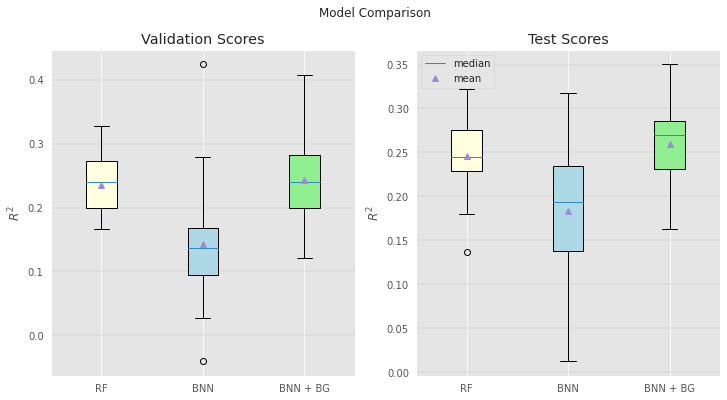

In [12]:
labels = ["RF", "BNN", "BNN + BG"]

rf_val_r2_scores, rf_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["val_r2_score"], \
                                               bnn_rf_bg_df[bnn_rf_bg_df["model"] == "RF"]["test_r2_score"]

bnn_val_r2_scores, bnn_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN"]["test_r2_score"]

bnn_bg_val_r2_scores, bnn_bg_test_r2_scores = bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["val_r2_score"], \
                                                  bnn_rf_bg_df[bnn_rf_bg_df["model"] == "BNN + BG"]["test_r2_score"]                                              

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax2.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

bplot1 = ax1.boxplot([rf_val_r2_scores, bnn_val_r2_scores, bnn_bg_val_r2_scores], showmeans=True, patch_artist=True, labels=labels)
bplot2 = ax2.boxplot([rf_test_r2_scores, bnn_test_r2_scores, bnn_bg_test_r2_scores], showmeans=True, patch_artist=True, labels=labels)

# fill with colors
colors = ['lightyellow' ,'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.suptitle("Model Comparison")
plt.legend([bplot1['medians'][0], bplot1['means'][0]], ['median', 'mean'])

ax1.set_ylabel("$R^{2}$")
ax1.set_title("Validation Scores")

ax2.set_ylabel("$R^{2}$")
ax2.set_title("Test Scores")

plt.show()

In [13]:
rf_test_r2_scores.std()

0.04499079968112092

In [14]:
bnn_bg_test_r2_scores.std()

0.05241289956379923

In [15]:
stats.ttest_rel(bnn_bg_test_r2_scores, bnn_test_r2_scores, alternative="greater")

Ttest_relResult(statistic=8.477441507332248, pvalue=3.505409890772487e-08)

In [16]:
from scipy import stats

stats.ttest_rel(bnn_bg_test_r2_scores, rf_test_r2_scores, alternative="greater")

Ttest_relResult(statistic=1.9510907439469571, pvalue=0.032975061812330744)

#### GP

In [107]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
                gp_dict["Gen"].append(-1)
                gp_dict["Ind"].append(idx)
                gp_dict["Fitness"].append(prog.fitness_)
                gp_dict["OOB_fitness"].append(prog.oob_fitness_)
                gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'sin', 'cos']

def train_linear_model(seed, X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=3, random_state=seed, shuffle=True)
    param_grid = {"alpha": np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid, 
                                            verbose=0, scoring="r2", cv=cv).fit(X_train, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    lin_model.fit(X_train, y_train)
    y_test_pred = lin_model.predict(X_test)

    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval

def train_gp(seed, X_train, X_train_2, X_test, y_train, y_train_2, y_test, num_models=5, sort_fit="OOB_fitness", verbose=0, num_gen=100, 
                        p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=200, n_components=50, generations=num_gen,
                                 function_set=function_set,
                           p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                           p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                           max_samples=subsample, verbose=verbose,
                           parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    gp_features_train, gp_train_df = gp_transform(gp_est, X_train_2, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_train_comb = np.concatenate([X_train_2, gp_features_train], axis=1)
    X_test_comb = np.concatenate([X_test, gp_features_test], axis=1)


    test_rmse_score, test_r2_score, test_pearson, test_pval = train_linear_model(seed, X_train_comb, X_test_comb, y_train_2, y_test)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_test_df

def train_gp_v2(seed, X_train, X_test, y_train,y_test, verbose=0, num_gen=100,
             p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicRegressor(population_size=1000, generations=num_gen,
                                 function_set=function_set,
                                 p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                                 p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                                 max_samples=subsample, verbose=verbose,
                                 parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    y_test_pred = gp_est.predict(X_test)
    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_est

In [85]:
import pickle
from tqdm import tqdm
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import pearsonr
import warnings
import optuna
warnings.filterwarnings("ignore")

epochs = 200
hidden_sizes = [1000, 500, 300, 100]
num_cycles = 10
batch_size = 80
lr_0 = 1e-3
sigma = 1.0
eta = 1.0
num_feats = [10, 20, 30, 40, 50]

num_gp_models = 5
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"


def cross_val_gp_train(seeds, X, y):
    for seed in tqdm(seeds):
        rng_key = jax.random.PRNGKey(seed)
        bnn_rf_gp_dict = {"seed": [], "model": [], "num_feats": [], "test_rmse_score": [],
                          "test_r2_score": [], "test_pcc": [], "test_pcc_pval": []}

        bnn_rf_dict = {"seed": [], "model": [], "test_rmse_score": [],
                       "test_r2_score": []}
        X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, random_state=seed, shuffle=True,
                                                                        test_size=0.2)
        X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True,
                                                                      random_state=seed, test_size=0.2)
        train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
        train_transformed = train_transformer.transform(X_train_df)
        val_transformed = train_transformer.transform(X_val_df)
        test_transformed = train_transformer.transform(X_test_df)

        X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
        X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
        X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)
        X_train, y_train = X_train_df.values, y_train_df.values
        X_val, y_val = X_val_df.values, y_val_df.values
        X_test, y_test = X_test_df.values, y_test_df.values

        # Train BNN and RF models and select features

        # if os.path.exists(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v2.csv"):
        #     bnn_dropout_loss_df = pd.read_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v2.csv")
        # else:
        #     bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, X_train, y_train, epochs, num_cycles, beta, lr_0,
        #                                                            disc_lr_0, batch_size, hidden_sizes, temp, sigma, eta, mu, J)
        #     bnn_dropout_loss_df = get_feats_dropout_loss(bg_bnn_model, states, disc_states, X_train, y_train)
        #     bnn_dropout_loss_df.to_csv(f"{save_dir}/dropout/bnn_dropout_loss_s_{seed}_v2.csv", index=False)

        # if os.path.exists(f"{save_dir}/configs/bnn_config_ft_sel_s_{seed}.pkl"):
        #     bnn_config = pickle.load(open(f"{save_dir}/configs/bnn_config_ft_sel_s_{seed}.pkl", "rb"))
        # else:
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(sampler=sampler)
        study.optimize(lambda trial: objective(trial, seed, X_train, X_val, y_train, y_val, J, epochs, num_cycles,
                                            batch_size, hidden_sizes, lr_0), timeout=300)
        bnn_config = study.best_params
        pickle.dump(bnn_config, open(f"{save_dir}/configs/bnn_config_bg_s_{seed}_v2.pkl", "wb"))

        disc_lr_0 = bnn_config["disc_lr"]
        temp  = bnn_config["temp"]
        mu = bnn_config["mu"]
        beta = bnn_config["beta"]

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=False)

        bg_bnn_model, states, disc_states = train_bg_bnn_model(seed, data_loader, epochs, num_cycles, beta, lr_0, disc_lr_0,
                                                               hidden_sizes, temp, sigma, eta, mu, J, act_fn=jax.nn.swish)

        bnn_rmse_test, bnn_r2_test = score_bg_bnn_model(bg_bnn_model, X_test, y_test, states, disc_states)

        # # gamma_mean = np.mean(np.array(disc_states), axis=0)
        # igs = np.zeros_like(X_val)
        # for i in range(X_val.shape[0]):
        #     igs[i] = integrated_gradients(bg_bnn_model, states, disc_states, X_val[i], y_val[i], 100)
        #
        # igs = jax.vmap(integrated_gradients, in_axes=(None, None, None, 0, 0, None))(bg_bnn_model, states, disc_states, X_val, y_val, 100)
        # igs_mean = np.mean(np.abs(igs), axis=0)
        # bnn_feat_idx = np.argsort(gamma_mean)[::-1][:num_feats]

        if os.path.exists(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl"):
            rf_model = pickle.load(open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "rb"))
        else:
            rf_model = train_rf_model(seed, X_train, y_train)
            pickle.dump(rf_model, open(f"{save_dir}/checkpoints/rf_model_s_{seed}.pkl", "wb"))

        rf_rmse_test, rf_r2_test = eval_rf_model(rf_model, X_test, y_test)


        bnn_rf_dict["seed"].append(seed)
        bnn_rf_dict["model"].append("RF")
        bnn_rf_dict["test_rmse_score"].append(rf_rmse_test)
        bnn_rf_dict["test_r2_score"].append(rf_r2_test)


        bnn_rf_dict["seed"].append(seed)
        bnn_rf_dict["model"].append("BNN + BG")
        bnn_rf_dict["test_rmse_score"].append(bnn_rmse_test)
        bnn_rf_dict["test_r2_score"].append(bnn_r2_test)

        # for num_feat in num_feats:
        #     bnn_feat_idx = np.argsort(gamma_mean)[::-1][:num_feat]
        #     rf_feat_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_feat]
        #     X_train_2, y_train_2 = jax.random.choice(rng_key, X_train, shape=(X_val.shape[0],), replace=False), jax.random.choice(rng_key, y_train, shape=(X_val.shape[0],), replace=False)
        #
        #     # Create new validation for training Linear Regression models same size as outer validation
        #     X_gp_train_rf, X_gp_train_2_rf, X_gp_val_rf, X_gp_test_rf = X_val[:,rf_feat_idx], X_train_2[:,rf_feat_idx], X_train[:,rf_feat_idx], X_test[:,rf_feat_idx]
        #     X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn = X_val[:,bnn_feat_idx], X_train_2[:,bnn_feat_idx], X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]
        #
        #     y_train_gp, y_train_gp_2, y_val_gp, y_test_gp = y_val, y_train_2, y_train, y_test
        #
        #     ## Run GP
        #     bnn_test_rmse_score, bnn_test_r2_score, bnn_test_pcc, bnn_test_pval = train_linear_model(seed, X_gp_train_2_bnn, X_gp_test_bnn, y_train_gp_2, y_test_gp)
        #     rf_test_rmse_score, rf_test_r2_score, rf_test_pcc, rf_test_pval = train_linear_model(seed, X_gp_train_2_rf, X_gp_test_rf, y_train_gp_2, y_test_gp)
        #
        #
        #     bnn_gp_test_rmse_score, bnn_gp_test_r2_score, bnn_gp_test_pcc, bnn_gp_test_pval, _ = train_gp(seed, X_gp_train_bnn, X_gp_train_2_bnn, X_gp_test_bnn,
        #                                                                                                   y_train_gp, y_train_gp_2, y_test_gp, num_models=1, verbose=0, p_cxvr=0.8, p_subt_mut=0.05,
        #                                                                                                   p_hmut=0.05, p_pmut=0.05, complexity_coef=0.001)
        #
        #
        #     rf_gp_test_rmse_score, rf_gp_test_r2_score, rf_gp_test_pcc, rf_gp_test_pval, _ = train_gp(seed, X_gp_train_rf, X_gp_train_2_rf, X_gp_test_rf,
        #                                                                                               y_train_gp, y_train_gp_2, y_test_gp, num_models=1, verbose=0, p_cxvr=0.8, p_subt_mut=0.05,
        #                                                                                               p_hmut=0.05, p_pmut=0.05, complexity_coef=0.001)
        #
        #
        #     # ======================== Save scores for compressed models =========================
        #
        #     bnn_rf_gp_dict["seed"].append(seed)
        #     bnn_rf_gp_dict["model"].append("RF + LR")
        #     bnn_rf_gp_dict["num_feats"].append(num_feat)
        #     bnn_rf_gp_dict["test_rmse_score"].append(rf_test_rmse_score)
        #     bnn_rf_gp_dict["test_r2_score"].append(rf_test_r2_score)
        #     bnn_rf_gp_dict["test_pcc"].append(rf_test_pcc)
        #     bnn_rf_gp_dict["test_pcc_pval"].append(rf_test_pval)
        #
        #     bnn_rf_gp_dict["seed"].append(seed)
        #     bnn_rf_gp_dict["model"].append("RF + LR + GP")
        #     bnn_rf_gp_dict["num_feats"].append(num_feat)
        #     bnn_rf_gp_dict["test_rmse_score"].append(rf_gp_test_rmse_score)
        #     bnn_rf_gp_dict["test_r2_score"].append(rf_gp_test_r2_score)
        #     bnn_rf_gp_dict["test_pcc"].append(rf_gp_test_pcc)
        #     bnn_rf_gp_dict["test_pcc_pval"].append(rf_gp_test_pval)
        #
        #     bnn_rf_gp_dict["seed"].append(seed)
        #     bnn_rf_gp_dict["model"].append("BNN + LR")
        #     bnn_rf_gp_dict["num_feats"].append(num_feat)
        #     bnn_rf_gp_dict["test_rmse_score"].append(bnn_test_rmse_score)
        #     bnn_rf_gp_dict["test_r2_score"].append(bnn_test_r2_score)
        #     bnn_rf_gp_dict["test_pcc"].append(bnn_test_pcc)
        #     bnn_rf_gp_dict["test_pcc_pval"].append(bnn_test_pval)
        #
        #
        #     bnn_rf_gp_dict["seed"].append(seed)
        #     bnn_rf_gp_dict["model"].append("BNN + LR + GP")
        #     bnn_rf_gp_dict["num_feats"].append(num_feat)
        #     bnn_rf_gp_dict["test_rmse_score"].append(bnn_gp_test_rmse_score)
        #     bnn_rf_gp_dict["test_r2_score"].append(bnn_gp_test_r2_score)
        #     bnn_rf_gp_dict["test_pcc"].append(bnn_gp_test_pcc)
        #     bnn_rf_gp_dict["test_pcc_pval"].append(bnn_gp_test_pval)
        #
        #
        #     # print(f"Num Feats {num_feat} - RF scores - LR: {rf_test_r2_score} GP: {rf_gp_test_r2_score}")
        #     # print(f"Num Feats {num_feat} - BNN scores - LR: {bnn_test_r2_score} GP: {bnn_gp_test_r2_score}")
        #
        # pd.DataFrame(bnn_rf_gp_dict).to_csv(f"{save_dir}/results/bnn_rf_gp_s_{seed}_gamma_mean_v7.csv", index=False)
        pd.DataFrame(bnn_rf_dict).to_csv(f"{save_dir}/results/bnn_bg_rf_s_{seed}_v5.csv", index=False)

        print(f"RF - test_rmse: {rf_rmse_test}, test_r2_score: {rf_r2_test}")
        print(f"BNN - test_rmse: {bnn_rmse_test}, test_r2_score: {bnn_r2_test}")

    print("Done")

In [ ]:
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [769,920,226,196]
bnn_rf_gp_dict = cross_val_gp_train(seeds, X_selected, target)

In [9]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57]
res_dfs = []
for seed in seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_gp_s_{seed}_ig_abs_v6.csv")
    res_dfs.append(df)

bnn_rf_df = pd.concat(res_dfs, axis=0)
bnn_rf_df.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score  test_r2_score  test_pcc  \
model         num_feats                                             
BNN + LR      10                0.537268       0.047827  0.268009   
              20                0.537873       0.046022  0.312778   
              30                0.545694       0.014559  0.314402   
              40                0.548733       0.005249  0.325595   
              50                0.562054      -0.041952  0.303852   
BNN + LR + GP 10                0.596980      -0.262101  0.217735   
              20                0.573259      -0.098103  0.275400   
              30                0.566625      -0.070660  0.304064   
              40                0.563732      -0.056073  0.311494   
              50                0.574822      -0.094130  0.299497   
RF + LR       10                0.494575       0.197003  0.458374   
              20                0.493651       0.197615  0.465853   
              30                0.488648       0.215022  0.480978   
              40                0.492449       0.202834  0.474456   
              50                0.494120       0.197730  0.473012   
RF + LR + GP  10                0.544896      -0.109444  0.429179   
              20                0.497218       0.185374  0.458679   
              30                0.494995       0.194069  0.471333   
              40                0.500833       0.174388  0.460211   
              50                0.501782       0.171145  0.459229   

                         test_pcc_pval  
model         num_feats                 
BNN + LR      10              0.119289  
              20              0.027440  
              30              0.031976  
              40              0.036093  
              50              0.043030  
BNN + LR + GP 10              0.199679  
              20              0.056152  
              30              0.041436  
              40              0.049129  
              50              0.058287  
RF + LR       10              0.000611  
              20              0.001160  
              30              0.000446  
              40              0.000963  
              50              0.001095  
RF + LR + GP  10              0.037417  
              20              0.001031  
              30              0.000402  
              40              0.001183  
              50              0.001432

In [10]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57]
res_dfs = []
for seed in seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_bg_rf_s_{seed}_v5.csv")
    res_dfs.append(df)

bnn_rf_df = pd.concat(res_dfs, axis=0)
bnn_rf_df.groupby(["model"]).mean().iloc[:,1:]

,test_rmse_score,test_r2_score
model,,
BNN + BG,0.481284,0.238046
RF,0.479711,0.245956


In [ ]:
bnn_rf_df

In [ ]:
bnn_rf_df = bnn_rf_df.reset_index().drop(index=[8, 9], axis=0).groupby(["model"]).mean()
bnn_rf_df

In [24]:
bnn_rf_gp_lsw = pd.read_csv(f"{save_dir}/bnn_rf_gp_feature_sel_summary.csv")
bnn_rf_gp_lsw = bnn_rf_gp_lsw.drop_duplicates().drop("Unnamed: 0", axis=1)
bnn_rf_gp_lsw.groupby(["model", "num_feats"]).mean().iloc[:,1:]

test_rmse_score  test_r2_score  test_pcc  \
model         num_feats                                             
BNN + LR      20                0.549379       0.003239  0.271716   
              40                0.546482       0.013174  0.337297   
              60                0.554629      -0.018310  0.335159   
BNN + LR + GP 20                0.555483      -0.019855  0.263980   
              40                0.550449      -0.001111  0.332696   
              60                0.561666      -0.044314  0.326638   
RF + LR       20                0.495686       0.191597  0.460010   
              40                0.503463       0.165533  0.452178   
              60                0.509864       0.141250  0.431336   
RF + LR + GP  20                0.498977       0.180815  0.456942   
              40                0.503225       0.165837  0.453768   
              60                0.511880       0.133692  0.432519   

                         test_pcc_pval  
model         num_feats                 
BNN + LR      20              0.103979  
              40              0.019269  
              60              0.026847  
BNN + LR + GP 20              0.093821  
              40              0.024275  
              60              0.030761  
RF + LR       20              0.000520  
              40              0.000141  
              60              0.000862  
RF + LR + GP  20              0.000486  
              40              0.000171  
              60              0.000989

In [57]:
save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
res_dfs = []
for seed in seeds:
    df = pd.read_csv(f"{save_dir}/results/bnn_rf_gp_s_{seed}_v4.csv")
    res_dfs.append(df)

bnn_rf_gp_df = pd.concat(res_dfs, axis=0)
bnn_rf_gp_df.groupby(["model", "num_feats"]).mean().iloc[:,1:]

,,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
model,num_feats,,,,
BNN + LR,20,0.535148,0.059113,0.310668,0.050418
BNN + LR + GP,20,0.553210,-0.009103,0.280440,0.094543
RF + LR,20,0.495686,0.191597,0.460010,0.000520
RF + LR + GP,20,0.499409,0.179732,0.457535,0.000252


In [58]:
bnn_rf_gp_df

,seed,model,num_feats,test_rmse_score,test_r2_score,test_pcc,test_pcc_pval
0,422,RF + LR,20,0.445575,0.137967,0.441134,0.000034
1,422,RF + LR + GP,20,0.440351,0.158062,0.437110,0.000040
2,422,BNN + LR,20,0.446160,0.135702,0.378847,0.000449
3,422,BNN + LR + GP,20,0.432252,0.188745,0.438863,0.000037
0,261,RF + LR,20,0.515131,0.064735,0.299998,0.006176
...,...,...,...,...,...,...,...
3,226,BNN + LR + GP,20,0.580038,0.131860,0.382773,0.000387
0,196,RF + LR,20,0.497757,0.171029,0.438416,0.000038
1,196,RF + LR + GP,20,0.497990,0.170254,0.439247,0.000037
2,196,BNN + LR,20,0.535433,0.040789,0.296835,0.006769


In [ ]:
# save_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
# seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
# res_dfs = []
# for seed in seeds:
#     df = pd.read_csv(f"{save_dir}/results/bnn_rf_gp_s_{seed}_v2.csv")
#     res_dfs.append(df)
#
# bnn_rf_gp_df_v2 = pd.concat(res_dfs, axis=0)
# bnn_rf_gp_df_v2.groupby(["model", "num_feats"]).mean().iloc[:,1:]